In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import random
import time
import warnings
import gc
import tracemalloc
import cProfile
import pstats
import sys
import pptk
import scipy.ndimage
from sortedcontainers import SortedSet

import json
import copy

from utils import *
#from lib.AcceleratorMethods.AcceleratorMethods import *

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 160

cmap = cm.get_cmap('viridis', 101)
viridis = np.ndarray((101, 4))
for i in range(0, 101):
    viridis[i] = cmap(i/100)
    
cmap = cm.get_cmap('magma', 101)
magma = np.ndarray((101, 4))
for i in range(0, 101):
    magma[i] = cmap(i/100)
    
cmap = cm.get_cmap('inferno', 101)
inferno = np.ndarray((101, 4))
for i in range(0, 101):
    inferno[i] = cmap(i/100)
    
cmap = cm.get_cmap('prism', 101)
prism = np.ndarray((101, 4))
for i in range(0, 101):
    prism[i] = cmap(i/100)
    
cmap = cm.get_cmap('flag', 101)
flag = np.ndarray((101, 4))
for i in range(0, 101):
    flag[i] = cmap(i/100)
    
cmap = cm.get_cmap('ocean', 101)
ocean = np.ndarray((101, 4))
for i in range(0, 101):
    ocean[i] = cmap(i/100)
    
cmap = cm.get_cmap('tab10', 10)
tab10 = np.ndarray((10, 4))
for i in range(0, 10):
    tab10[i] = cmap(i/10)
    
cmap = cm.get_cmap('Set1', 9)
set1 = np.ndarray((9, 4))
for i in range(0, 9):
    set1[i] = cmap(i/9)
    
    
import warnings
warnings.filterwarnings('error', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# taken from https://github.com/grantjenks/python-sortedcontainers/issues/53
class FasterSortedSet(SortedSet):
    def union(self, *iterables):
        if (self and len(iterables) == 1
                and isinstance(iterables[0], SortedSet)
                and iterables[0]
                and self._list._lists[-1][-1] < iterables[0]._list._lists[0][0]):
            that = iterables[0]
            result = FasterSortedSet()
            _set = result._set
            _set.update(self)
            _set.update(that)
            _list = result._list
            _list._lists.extend(list(sublist) for sublist in self._list._lists)
            _list._maxes.extend(self._list._maxes)
            _list._lists.extend(list(sublist) for sublist in that._list._lists)
            _list._maxes.extend(that._list._maxes)
            _list._len = len(_set)
            return result
        else:
            return self.__class__(
                chain(iter(self), *iterables),
                key=self._key,
                load=self._load
            )

    __or__ = union
    __ror__ = __or__

In [3]:
import Cython
%load_ext Cython

In [4]:
%%cython
cimport cython
import numpy as np
cimport numpy as np


@cython.boundscheck(False)
@cython.wraparound(False)
def superimpose_potential(np.float32_t[:,:,:,:] pot_field, np.float64_t[:] center, unsigned long scale, double radius, np.float32_t[:,:,:,:] template, unsigned long diameter):
    cdef int[:] scaled_center = np.array([0,0,0], dtype=np.int32)
    scaled_center[0] = np.round(center[0] * scale).astype(np.int32) % pot_field.shape[0]
    scaled_center[1] = np.round(center[1] * scale).astype(np.int32) % pot_field.shape[1]
    scaled_center[2] = np.round(center[2] * scale).astype(np.int32) % pot_field.shape[2]
    #print("Scaled center {}".format(scaled_center))
    #Vmin is at r=2^(1/6)*zero_pot
    cdef np.float32_t zero_pot = radius / 2**(1/5) * scale # in indices
    cdef int low = -((diameter-1)//2)
    cdef int high = (diameter+1)//2
    cdef Py_ssize_t x = (pot_field.shape[0])
    cdef Py_ssize_t y = (pot_field.shape[1])
    cdef Py_ssize_t z = (pot_field.shape[2])
    
    cdef np.float32_t[:,:,:,:] pot_view = pot_field
    cdef np.float32_t[:,:,:,:] tmp_view = template
    
    cdef Py_ssize_t i, ii, j, jj, k, kk
    for i in range(low, high):
        ii = (scaled_center[0] + i) % x
        idist = (i)**2
        for j in range(low, high):
            jj = (scaled_center[1] + j) % y
            jdist = (j)**2
            for k in range(low, high):
                kk = scaled_center[2] + k
                if kk < 0 or kk > z-1:
                    continue
                if i == 0 and j == 0 and k == 0:
                    pot_view[ii,jj,kk,0] = 0
                    pot_view[ii,jj,kk,1] = 0
                    pot_view[ii,jj,kk,2] = 0
                    pot_view[ii,jj,kk,3] = np.inf
                
                #r = np.sqrt(idist + jdist + (k)**2)
                #magnitude = tmp_view[i-low,j-low,k-low,3]#(zero_pot/r)**12 - (zero_pot/r)**6
                #direction = tmp_view[i-low,j-low,k-low,:3]#np.array([i,j,k]) / distance3D([i,j,k], [0,0,0]) * magnitude/np.abs(magnitude) # get direction
                #magnitude = np.abs(magnitude) # set magnitude to the absolute value
                
                pot_view[ii,jj,kk,0] = pot_view[ii,jj,kk,3]*pot_view[ii,jj,kk,0] + tmp_view[i-low,j-low,k-low,3]*tmp_view[i-low,j-low,k-low,0]
                pot_view[ii,jj,kk,1] = pot_view[ii,jj,kk,3]*pot_view[ii,jj,kk,1] + tmp_view[i-low,j-low,k-low,3]*tmp_view[i-low,j-low,k-low,1]
                pot_view[ii,jj,kk,2] = pot_view[ii,jj,kk,3]*pot_view[ii,jj,kk,2] + tmp_view[i-low,j-low,k-low,3]*tmp_view[i-low,j-low,k-low,2]
                #pot_view[ii,jj,kk,3] = np.sqrt(pot_view[ii,jj,kk,0]**2 + pot_view[ii,jj,kk,1]**2 + pot_view[ii,jj,kk,2]**2)
                pot_view[ii,jj,kk,3] = pot_view[ii,jj,kk,3] + tmp_view[i-low, j-low, k-low, 3]
                if pot_view[ii,jj,kk,3] == 0.0:
                    pot_view[ii,jj,kk,0] = 0.0
                    pot_view[ii,jj,kk,1] = 0.0
                    pot_view[ii,jj,kk,2] = 0.0
                else:
                    pot_view[ii,jj,kk,0] = pot_view[ii,jj,kk,0]/pot_view[ii,jj,kk,3]
                    pot_view[ii,jj,kk,1] = pot_view[ii,jj,kk,1]/pot_view[ii,jj,kk,3]
                    pot_view[ii,jj,kk,2] = pot_view[ii,jj,kk,2]/pot_view[ii,jj,kk,3]
#     ii = scaled_center[0] + low
#     jj = scaled_center[1] + low
#     kk = scaled_center[2] + low
#     vectors = [0, 1, 2]
#     if scaled_center[0] > -low and scaled_center[0] + high < x-1:
#         if scaled_center[1] > -low and scaled_center[1] + high < y-1:
#             if scaled_center[2] > -low and scaled_center[2] + high < z-1:
#                 # easy case: entire added field doesn't cross boundaries
#                 region = pot_field[ii:ii+diameter,jj:jj+diameter,kk:kk+diameter,:]
#                 print(region.shape, template.shape)
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:,:,3]*template[:,:,:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#             elif scaled_center[2] <= -low:
#                 # 0<x<L, 0<y<L, 0=z<h
#                 region = pot_field[ii:ii+diameter,jj:jj+diameter,0:kk+diameter,:]
#                 t = template[:,:,-kk-diameter:,:]
#                 print(scaled_center, region.shape, template[:,:,-kk-diameter:,:].shape, low, kk)
#                 cs = [region[:,:,:,3]*region[:,:,:,i] + t[:,:,:,3]*t[:,:,:,i] for i in vectors]
#                 region[:,:,:,:3] = np.stack(cs, axis=3)
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.stack([region[:,:,:,0]/region[:,:,:,3], region[:,:,:,1]/region[:,:,:,3], region[:,:,:,2]/region[:,:,:,3], region[:,:,:,3]], axis=3)
#                 region = np.where(region==np.nan, 0, region)
#             else:
#                 # 0<x<L, 0<y<L, 0<z=h
#                 region = pot_field[ii:ii+diameter,jj:jj+diameter,kk:-1,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:,:low,3]*template[:,:,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#         elif scaled_center[0] <= -low:
#             if scaled_center[2] > -low and scaled_center[2] + high < z-1:
#                 # 0<x<L, 0=y<L, 0<z<h
#                 region = pot_field[ii:ii+diameter,0:jj+diameter,kk:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,-low:,:,3]*template[:,-low:,:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 #0<x<L, y<0, 0<z<h
#                 region = pot_field[ii:ii+diameter,low:,kk:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:,3]*template[:,:low,:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#             elif scaled_center[2] <= -low:
#                 # 0<x<L, 0=y<L, 0=z<h
#                 region = pot_field[ii:ii+diameter,0:jj+diameter,0:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,-low:,-low:,3]*template[:,-low:,-low:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 #0<x<L, y<0, 0=z<h
#                 region = pot_field[ii:ii+diameter,low:,0:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:low,3]*template[:,:low,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#             else:
#                 # 0<x<L, 0=y<L, 0<z=h
#                 region = pot_field[ii:ii+diameter,0:jj+diameter,kk:-1,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,-low:,:low,3]*template[:,-low:,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 # 0<x<L, y<0, 0<z=h
#                 region = pot_field[ii:ii+diameter,low:,kk:-1,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:low,3]*template[:,:low,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#         else:
#             if scaled_center[2] > -low and scaled_center[2] + high < z-1:
#                 # 0<x<L, 0<y=L, 0<z<h
#                 region = pot_field[ii:ii+diameter,jj:,kk:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,low:,:,3]*template[:,low:,:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 #0<x<L, y>L, 0<z<h
#                 region = pot_field[ii:ii+diameter,low:,kk:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:,3]*template[:,:low,:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#             elif scaled_center[2] <= -low:
#                 # 0<x<L, 0=y<L, 0=z<h
#                 region = pot_field[ii:ii+diameter,0:jj+diameter,0:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,-low:,-low:,3]*template[:,-low:,-low:,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 #0<x<L, y<0, 0=z<h
#                 region = pot_field[ii:ii+diameter,low:,0:kk+diameter,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:low,3]*template[:,:low,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
#             else:
#                 # 0<x<L, 0=y<L, 0<z=h
#                 region = pot_field[ii:ii+diameter,0:jj+diameter,kk:-1,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,-low:,:low,3]*template[:,-low:,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
                
#                 # 0<x<L, y<0, 0<z=h
#                 region = pot_field[ii:ii+diameter,low:,kk:-1,:]
#                 region[:,:,:,:3] = region[:,:,:,3]*region[:,:,:,:3] + template[:,:low,:low,3]*template[:,:low,:low,:3]
#                 region[:,:,:,3] = np.sqrt(region[:,:,:,0]**2 + region[:,:,:,1]**2 + region[:,:,:,2]**2)
#                 region = np.where(region[:,:,:,3]==0.0, [0,0,0,0], [region[:,:,:,:3]/region[:,:,:,3], region[:,:,:,3]])
    return

@cython.boundscheck(False)
@cython.wraparound(False)
def shortest_distance_line_to_point(double[:] line_1, double[:] line_2, np.float32_t[:] point):
    x = np.array([line_1[0] - line_2[0], line_1[1] - line_2[1], line_1[2] - line_2[2]])
    pmq = np.array([point[0] - line_2[0], point[1] - line_2[1], point[2] - line_2[2]])
    t = np.dot(pmq, x)/np.dot(x, x)
    r = np.linalg.norm(t*x - pmq)
    return r

In [5]:
def distance3D(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 + (p1[2] - p2[2])**2)

def distance3DPBC(p1, p2, L):
    # distance in x considering PBC
    if (p1[0] - p2[0]) > L/2:
        dx = p1[0] - p2[0] - L
    elif p1[0] - p2[0] < -L/2:
        dx = p1[0] - p2[0] + L
    else:
        dx = p1[0] - p2[0]
    # distance in y considering PBC
    if (p1[1] - p2[1]) > L/2:
        dy = p1[1] - p2[1] - L
    elif p1[1] - p2[1] < -L/2:
        dy = p1[1] - p2[1] + L
    else:
        dy = p1[1] - p2[1]
    return np.sqrt(dx**2 + dy**2 + (p1[2] - p2[2])**2)

# returns distance^2 (for faster comparisons)
def distance3D2PBC(p1, p2, L):
    # distance in x considering PBC
    if (p1[0] - p2[0]) > L/2:
        dx = p1[0] - p2[0] - L
    elif p1[0] - p2[0] < -L/2:
        dx = p1[0] - p2[0] + L
    else:
        dx = p1[0] - p2[0]
    # distance in y considering PBC
    if (p1[1] - p2[1]) > L/2:
        dy = p1[1] - p2[1] - L
    elif p1[1] - p2[1] < -L/2:
        dy = p1[1] - p2[1] + L
    else:
        dy = p1[1] - p2[1]
    return dx**2 + dy**2 + (p1[2] - p2[2])**2

def distance2D2PBC(p1, p2, L):
    # distance in x considering PBC
    if (p1[0] - p2[0]) > L/2:
        dx = p1[0] - p2[0] - L
    elif p1[0] - p2[0] < -L/2:
        dx = p1[0] - p2[0] + L
    else:
        dx = p1[0] - p2[0]
    # distance in y considering PBC
    if (p1[1] - p2[1]) > L/2:
        dy = p1[1] - p2[1] - L
    elif p1[1] - p2[1] < -L/2:
        dy = p1[1] - p2[1] + L
    else:
        dy = p1[1] - p2[1]
    return dx**2 + dy**2

# p is the current point position, n the unit vector, and step_size the magnitude
def step_along_line(p, n, step_size):
    return p + n * step_size

In [6]:
class SpatialBins:
    def __init__(self, length, height, bin_size, cython=False, *args, **kwargs):
        self.length = length
        self.height = height
        self.bin_size = bin_size
        self.bins_side = int(length / bin_size)
        self.bins_vertical = int(height / bin_size)
        
        self.bins_in_layer = int(self.bins_side**2)
        self.bin_nums = int(self.bins_in_layer * self.bins_vertical)
        self.bins = [[] for _ in range(self.bin_nums)]
        print("Total number of bins: {}\n\tBins in x-y: {}\n\tBins to top: {} ".format(len(self.bins), self.bins_in_layer, self.bins_vertical))
    
    def find_bin(self, position):
        if position[2] > self.bin_size * self.bins_vertical:
            for i in range(self.bins_in_layer):
                self.bins.append([])
            self.bins_vertical += 1
        spacex = int(np.floor((position[0] % self.length)//self.bin_size))
        spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        spacez = int(np.floor(position[2]//self.bin_size))
        
        idx = spacex + spacey*self.bins_side + spacez*self.bins_in_layer
        #print(position % (self.length, self.length, np.inf), idx, spacex, spacey, spacez, bin_size)
        
        return self.bins[idx]
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins(self, center, radius):
        center_bin = self.find_bin(center)
        temp = [center_bin]
        
        left_back_lower_bin = self.find_bin((center + np.array(([-radius, -radius, -radius]))) % [self.length, self.length, self.height])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin((center + np.array([-radius, radius, -radius])) % [self.length, self.length, self.height])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        left_back_upper_bin = self.find_bin((center + np.array([-radius, -radius, radius])) % [self.length, self.length, self.height])
        if left_back_upper_bin not in temp:
            temp.append(left_back_upper_bin)
            
        left_front_upper_bin = self.find_bin((center + np.array([-radius, radius, radius])) % [self.length, self.length, self.height])
        if left_front_upper_bin not in temp:
            temp.append(left_front_upper_bin)
            
        right_back_lower_bin = self.find_bin((center + np.array([radius, -radius, -radius])) % [self.length, self.length, self.height])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin((center + np.array([radius, radius, -radius])) % [self.length, self.length, self.height])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
            
        right_back_upper_bin = self.find_bin((center + np.array([radius, -radius, radius])) % [self.length, self.length, self.height])
        if right_back_upper_bin not in temp:
            temp.append(right_back_upper_bin)
            
        right_front_upper_bin = self.find_bin(center + np.array([radius, radius, radius]))
        if right_front_upper_bin not in temp:
            temp.append(right_front_upper_bin)
            
        return temp
    
    def find_bin_idx(self, position):
        if position[2] > self.bin_size * self.bins_vertical:
            for i in range(self.bins_in_layer):
                self.bins.append([])
            self.bins_vertical+= 1
        spacex = int(np.floor((position[0] % self.length)//self.bin_size))
        spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        spacez = int(np.floor(position[2]//bin_size))
        
        idx = spacex + spacey*self.bins_side + spacez*self.bins_in_layer
        
        return idx
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins_idx(self, center, radius):
        center_bin = self.find_bin_idx(center)
        
        temp = [center_bin]
        
        #for i in [-1, 0, 1]:
        #    for j in [-1, 0, 1]:
        #        for k in [-1, 0, 1]:
        #            if i == 0 and j == 0 and k == 0:
        #                continue           
        
        left_back_lower_bin = self.find_bin_idx((center + np.array(([-radius, -radius, -radius]))) % [self.length, self.length, self.height])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin_idx((center + np.array([-radius, radius, -radius])) % [self.length, self.length, self.height])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        left_back_upper_bin = self.find_bin_idx((center + np.array([-radius, -radius, radius])) % [self.length, self.length, self.height])
        if left_back_upper_bin not in temp:
            temp.append(left_back_upper_bin)
            
        left_front_upper_bin = self.find_bin_idx((center + np.array([-radius, radius, radius])) % [self.length, self.length, self.height])
        if left_front_upper_bin not in temp:
            temp.append(left_front_upper_bin)
            
        right_back_lower_bin = self.find_bin_idx((center + np.array([radius, -radius, -radius])) % [self.length, self.length, self.height])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin_idx((center + np.array([radius, radius, -radius])) % [self.length, self.length, self.height])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
            
        right_back_upper_bin = self.find_bin_idx((center + np.array([radius, -radius, radius])) % [self.length, self.length, self.height])
        if right_back_upper_bin not in temp:
            temp.append(right_back_upper_bin)
            
        right_front_upper_bin = self.find_bin_idx(center + np.array([radius, radius, radius]))
        if right_front_upper_bin not in temp:
            temp.append(right_front_upper_bin)
            
        return temp
    
    # return particles that share bins
    def get_nearby_particles(self, center, radius):
        bins = self.find_bins(center, radius)
        
        if bins is []:
            return [] # should never happen
        
        temp = []
        for b in bins:
            if len(b) > 0:
                for i in b:
                    if i not in temp:
                        temp.append(i)
        return temp
        
    def check_collision(self, center, radius, atoms):
        if(center[2] - radius < 0):
            return 2 # collision with substrate
        potential_collisions = self.get_nearby_particles(center, radius)
        if potential_collisions == []:
            return 0 # no nearby atoms
        for c in potential_collisions:
            if distance3D2PBC(atoms[c,:3], center, self.length) < (atoms[c,4] + radius)**2:
                return 3 + c # collision
        return 1 # no collision but atoms nearby
    
    def are_nearby_bins_empty(self, center, radius):
        bins = self.find_bins(center, radius)
        if bins is []:
            return []
        for b in bins:
            if len(b) > 0:
                return False
        return True
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def add_to_bins(self, center, radius, idx):
        bins = self.find_bins(center, radius)
        for b in bins:
            b.append(idx)
        return
    
    
    # get position at edge of current bin given direction and radius such that the particle is still entirely within the bin
    # could be optimized more in the case where it's within multiple bins, careful then with nonzero phi because it might pass into another 
    #   bin in the interim
    # currently works only in +x direction
    def bin_edge(self, center, radius, direction):
        bins = self.find_bins_idx(center, radius)
        
        if len(bins) > 1:
            return np.array((np.nan, np.nan, np.nan))
        
        if bins is []: 
            return np.array((np.nan, np.nan, np.nan)) # should never happen
        
        
        candidates = np.zeros((len(bins), 3)) + np.inf
        
        for i in range(len(bins)):
            #spacex = int(np.floor(position[0]//bin_size))
            #spacey = int(np.floor((position[1] % self.length)//bin_size))
            #spacez = int(np.floor(position[2]//bin_size))
            
            if direction[0] > 0:
                x = (center[0] % self.length) // bin_size * bin_size + bin_size
            else:
                x = (center[0] % self.length) // bin_size * bin_size
#             if direction[1] > 0:
#                 y = center[1] // bin_size * bin_size + bin_size
#             else:
#                 y = center[1] // bin_size * bin_size
            z = center[2] // bin_size * bin_size
            
            manhattan = np.array([x-radius-center[0] % self.length/direction[0], 0, z - radius - center[2]/direction[2]])
            side = (np.abs(manhattan[0]) < np.abs(manhattan[2])) # true if it collides at the side rather than the bottom
            #print(center, manhattan, np.abs(x-radius-center[0] % self.length), np.abs(z-radius-center[2]))
            if side:
                candidates[i,:] = np.array([x-radius, center[1], center[2] + manhattan[0]*direction[2]])
            else:
                candidates[i,:] = np.array([center[0] + manhattan[2]*direction[0], center[1], z-radius])
        return candidates[0,:]
        

In [7]:


class Corridors:
    def __init__(self, length, bin_size, cython=False, *args, **kwargs):
        self.length = length
        self.bin_size = bin_size
        self.bins_side = int(length / bin_size)
        
        self.bin_nums = int(self.bins_side**2)
        #self.bins = [[] for _ in range(self.bin_nums)]
        #for b in self.bins:
        #    b = SortedSet(key=lambda position: position[1])
        self.bins = [SortedSet(key=lambda position: position[1])] * self.bin_nums
        print("Total number of bins: {}".format(len(self.bins)))
        
    def find_bin(self, position):
        spacex = int(np.floor((position[0] % self.length)//self.bin_size))
        spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        
        idx = spacex + spacey*self.bins_side
        #print(position % (self.length, self.length, np.inf), idx, spacex, spacey, spacez, bin_size)
        
        return self.bins[idx]
    
    # over-inclusive as it assumes a square with side length 2x radius
    def add_to_bins(self, center, radius, idx):
        bins = self.find_bins(center, radius)
        for b in bins:
            b.add((idx, center[2]))
        return
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins(self, center, radius):
        center_bin = self.find_bin(center)
        print(center_bin)
        temp = [center_bin]
        
        left_back_lower_bin = self.find_bin((center[:1] + np.array(([-radius, -radius]))) % [self.length, self.length])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin((center[:1] + np.array([-radius, radius])) % [self.length, self.length])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        right_back_lower_bin = self.find_bin((center[:1] + np.array([radius, -radius])) % [self.length, self.length])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin((center[:1] + np.array([radius, radius])) % [self.length, self.length])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
        
        return temp
    
    def find_bin_idx(self, position):
        spacex = int(np.floor((position[0] % self.length)//self.bin_size))
        spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        
        idx = spacex + spacey*self.bins_side
        
        return idx
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins_idx(self, center, radius):
        center_bin = self.find_bin_idx(center)
        temp = [center_bin]
        
        left_back_lower_bin = self.find_bin_idx((center[:1] + np.array(([-radius, -radius]))) % [self.length, self.length])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin_idx((center[:1] + np.array([-radius, radius])) % [self.length, self.length])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        right_back_lower_bin = self.find_bin_idx((center[:1] + np.array([radius, -radius])) % [self.length, self.length])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin_idx((center[:1] + np.array([radius, radius])) % [self.length, self.length])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
            
        return temp
    
    # return particles that share bins
    def get_nearby_particles(self, center, radius):
        bins = self.find_bins(center, radius)
        
        if bins is []:
            return [] # should never happen
        
        temp = []
        for b in bins:
            if len(b) > 0:
                for i in b:
                    if i not in temp:
                        temp.append(i)
        return temp
    
    def drop_particle(self, center, radius, atoms):
        bins = SortedSet(key=lambda position: position[2])
        # combine the bins into one larger bin
        fbins = self.find_bins(center, radius)
        for b in fbins:
            bins |= b
        for i in range(len(bins)-1, 0, -1):
            # check collision with bins[i][0]-th particle
            particle = atoms[bins[i][0],:]
            xy_distance2 = distance2D2PBC(particle[:3], center, self.length)
            radii2 = (particle[4] + radius)**2
            if xy_distance2 < radii2:
                z = np.sqrt(radii2 - xy_distance2) + particle[2]
                return z, bins[i][0]
        return 0, -1
        
    def check_collision(self, center, radius, atoms):
        if(center[2] - radius < 0):
            return 2 # collision with substrate
        potential_collisions = self.get_nearby_particles(center, radius)
        if potential_collisions == []:
            return 0 # no nearby atoms
        for c in potential_collisions:
            if distance3D2PBC(atoms[c,:3], center, self.length) < (atoms[c,4] + radius)**2:
                return 3 + c # collision
        return 1 # no collision but atoms nearby

In [8]:
from sortedcontainers import SortedSet

class SlantedCorridors:
    def __init__(self, length, bin_size, theta, height, verbose=False, *args, **kwargs):
        self.length = length
        self.theta = theta
        self.tantheta = tand(theta)
        self.cos1theta = cosd(theta)
        self.sin1theta = sind(theta)
        self.height = height
        self.bin_size = bin_size
        self.bins_side = int(length / bin_size)
        
        self.bin_nums = int(self.bins_side**2)
        self.bins = []
        #self.bins = [[] for _ in range(self.bin_nums)]
        #for b in self.bins:
        #    b = SortedSet(key=lambda position: position[1])
        #self.bins = [FasterSortedSet(key=lambda position: position[1])] * self.bin_nums
        for i in range(self.bin_nums):
            self.bins.append(FasterSortedSet(key=lambda position: position[1]))
        self.bins = [FasterSortedSet(key=lambda position: position[1])] * self.bin_nums
        print("Total number of bins: {}".format(len(self.bins)))
        
        self.verbose = verbose
        
    def find_bin(self, position):
        try:
            adjusted_x = position[2] * self.tantheta + position[0]
            spacex = int(np.floor((adjusted_x % self.length)//self.bin_size))
            spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        except FloatingPointError:
            raise FloatingPointError("\n*\tposition: {}\n*\tself.tantheta: {}\n*\tself.length: {}\n*\tself.bin_size: {}".format(position, self.tantheta, self.length, self.bin_size))
        
        idx = spacex + spacey*self.bins_side
        #print(position % (self.length, self.length, np.inf), idx, spacex, spacey, spacez, bin_size)
        
        return self.bins[idx]
    
    # over-inclusive as it assumes a square with side length 2x radius
    def add_to_bins(self, center, radius, idx):
        bins = self.find_bins(center, radius)
        priority = self.calc_priority(center)
        for b in bins:
            b.add((idx, priority))
        return
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins(self, center, radius):
        center_bin = self.find_bin(center)
        temp = [center_bin]
        
        left_back_lower_bin = self.find_bin((center + np.array(([-radius, -radius, -radius]))) % [self.length, self.length, np.inf])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin((center + np.array([-radius, radius, -radius])) % [self.length, self.length, np.inf])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        left_back_upper_bin = self.find_bin((center + np.array([-radius, -radius, radius])) % [self.length, self.length, np.inf])
        if left_back_upper_bin not in temp:
            temp.append(left_back_upper_bin)
            
        left_front_upper_bin = self.find_bin((center + np.array([-radius, radius, radius])) % [self.length, self.length, np.inf])
        if left_front_upper_bin not in temp:
            temp.append(left_front_upper_bin)
            
        right_back_lower_bin = self.find_bin((center + np.array([radius, -radius, -radius])) % [self.length, self.length, np.inf])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin((center + np.array([radius, radius, -radius])) % [self.length, self.length, np.inf])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
            
        right_back_upper_bin = self.find_bin((center + np.array([radius, -radius, radius])) % [self.length, self.length, np.inf])
        if right_back_upper_bin not in temp:
            temp.append(right_back_upper_bin)
            
        right_front_upper_bin = self.find_bin((center + np.array([radius, radius, radius])) % [self.length, self.length, np.inf])
        if right_front_upper_bin not in temp:
            temp.append(right_front_upper_bin)
        
        return temp
    
    def find_bin_idx(self, position):
        adjusted_x = position[2] * self.tantheta + position[0]
        spacex = int(np.floor((adjusted_x % self.length)//self.bin_size))
        spacey = int(np.floor((position[1] % self.length)//self.bin_size))
        
        idx = spacex + spacey*self.bins_side
        if self.verbose:
            print("Position: {}".format(position))
            #print("self.tandtheta: {}, {}".format(self.tantheta, tand(self.theta)))
            print("adjusted_x: {}".format(adjusted_x))
            print("Indices: {}, {}, {}".format(spacex, spacey, idx))
        return idx
    
    # over-inclusive as it assumes a cube with side length 2x radius
    def find_bins_idx(self, center, radius):
        center_bin = self.find_bin_idx(center)
        temp = [center_bin]
        
        left_back_lower_bin = self.find_bin_idx((center + np.array(([-radius, -radius, -radius]))) % [self.length, self.length, self.height])
        if left_back_lower_bin not in temp:
            temp.append(left_back_lower_bin)
            
        left_front_lower_bin = self.find_bin_idx((center + np.array([-radius, radius, -radius])) % [self.length, self.length, self.height])
        if left_front_lower_bin not in temp:
            temp.append(left_front_lower_bin)
        
        left_back_upper_bin = self.find_bin_idx((center + np.array([-radius, -radius, radius])) % [self.length, self.length, self.height])
        if left_back_upper_bin not in temp:
            temp.append(left_back_upper_bin)
            
        left_front_upper_bin = self.find_bin_idx((center + np.array([-radius, radius, radius])) % [self.length, self.length, self.height])
        if left_front_upper_bin not in temp:
            temp.append(left_front_upper_bin)
            
        right_back_lower_bin = self.find_bin_idx((center + np.array([radius, -radius, -radius])) % [self.length, self.length, self.height])
        if right_back_lower_bin not in temp:
            temp.append(right_back_lower_bin)
            
        right_front_lower_bin = self.find_bin_idx((center + np.array([radius, radius, -radius])) % [self.length, self.length, self.height])
        if right_front_lower_bin not in temp:
            temp.append(right_front_lower_bin)
            
        right_back_upper_bin = self.find_bin_idx((center + np.array([radius, -radius, radius])) % [self.length, self.length, self.height])
        if right_back_upper_bin not in temp:
            temp.append(right_back_upper_bin)
            
        right_front_upper_bin = self.find_bin_idx(center + np.array([radius, radius, radius]))
        if right_front_upper_bin not in temp:
            temp.append(right_front_upper_bin)
            
        return temp
    
    # return particles that share bins
    def get_nearby_particles(self, center, radius):
        bins = self.find_bins(center, radius)
        
        if bins is []:
            return [] # should never happen
        
        temp = []
        for b in bins:
            if len(b) > 0:
                for i in b:
                    if i not in temp:
                        temp.append(i)
        return temp
    
    def drop_particle(self, center, radius, atoms, profile=False):
        if profile:
            pr = cProfile.Profile()
            pr.enable()
        bins = FasterSortedSet(key=lambda position: position[1])
        # combine the bins into one larger bin
        fbins = self.find_bins(center, radius)
        for b in fbins:
            bins |= b
        adjusted_x = center[2] * self.tantheta + center[0]
        factor = adjusted_x // self.length
        adjusted_x %= self.length
        center_float = center.astype(float)
        
        
        for i in range(0, len(bins)):
            # check collision with bins[i][0]-th particle
            particle = atoms[bins[len(bins) - i-1][0],:]
            rs = radius + particle[4]
                
            x_on_particle_z = (center[2] - particle[2]) * self.tantheta + center[0] # x coordinate on z=particle[2] plane
            factor = x_on_particle_z // self.length                   # get multiple of self.length to shift by
            x_on_particle_z %= self.length                            # restrict x coordinate within PBC
            
            #center_proj_sub = np.array([x_on_particle_z, center[1], particle[2]])
            #center_proj_height = center_float - [factor*self.length, 0, 0]
            
            offset = [0,0,0]
            # offset_x, shift center nearer to account for PBC
            #if particle[0] < rs and center_proj_sub[0] > self.length - rs:
            if particle[0] - x_on_particle_z < -self.length/2:
                offset[0] = -self.length
            #elif particle[0] > self.length - rs and center_proj_sub[0] < rs:
            elif particle[0] - x_on_particle_z > self.length/2:
                offset[0] = self.length
            # offset_y, shift center nearer to account for PBC
            #if particle[1] < rs and center_proj_sub[1] > self.length - rs:
            if particle[1] - center[1] < -self.length/2:
                offset[1] = -self.length
            #elif particle[1] > self.length - rs and center_proj_sub[1] < rs:
            elif particle[1] - center[1] > self.length/2:
                offset[1] = self.length
            
            #proj_x = particle[2] * self.tantheta + center[0]
            #print('\t{}'.format(particle[:3]))
            
            #d = shortest_distance_line_to_point(center_proj_height + offset, center_proj_sub+offset, particle)
            radii2 = rs**2
            
            
                
            # rotate axes by theta degrees about y-axis into new coordinate system so that z' axis is unimportant
            #rotx = (center_proj_height[0] - particle[0] + offset[0])*self.cos1theta + (center_proj_height[2] - particle[2])*self.sin1theta
            #d2 = rotx**2 + (center_proj_height[1] - particle[1] + offset[1])**2
            rotx = (center_float[0] - factor*self.length - particle[0] + offset[0])*self.cos1theta + (center_float[2] - particle[2])*self.sin1theta
            d2 = rotx**2 + (center_float[1] - particle[1] + offset[1])**2
            
            if self.verbose:
                print("Generated position: {}".format(center))
                print("x-coordinate in new coordinate system: {}".format(rotx))
                print("Offset: {}".format(offset))
                #print("center_proj_height + offset: {}".format(center_proj_height+offset))
                #print("center_proj_sub + offset: {}".format(center_proj_sub+offset))
                #print("Adjusted generated position: {}".format(center_proj_height))
                print("Existing particle position being considered: {}".format(particle[:3]))
                #print("Offset (if any): {}".format(offset))
                print("Minimum distance^2 between: {}".format(d2))
                print("Radii added together: {}".format(rs))
                
            if radii2 > d2:
                # it collides, calculate the new position
                rotz = np.sqrt(radii2 - d2)
                z = rotx*self.sin1theta + rotz*self.cos1theta + particle[2]
                x = rotx*self.cos1theta - rotz*self.sin1theta + particle[0]

                if z < radius:
                    # if it would collide with the surface below the substrate for this particle then we can skip this particle
                    continue
                if self.verbose:
                    print("Particles collide.")
                    print("Coordinates in new coordinate system: {}".format([rotx, center[1], rotz]))
                    print("Distance: {}".format(np.sqrt((x - particle[0])**2 + (center[1] - particle[1])**2 + (z - particle[2])**2)))
#                     print("Start: {}".format(center_proj_height))
#                     print("Start (reprojected): {}".format(center_proj_height + offset))
#                     print("Target: {}".format(center_proj_sub))
#                     print("Target (reprojected): {}".format(center_proj_sub+offset))
                    print("Collision position: {}".format([x, center[1], z]))
                    print("Colliding atom position: {}\n".format(particle[:3]))
                #print("Hit particle: {} -> {}".format(center, [x, center[1], z]))
                if profile:
                    pr.disable()
                    p = pstats.Stats(pr)
                    p.sort_stats('time').print_stats()
                    #pr.print_stats()
                return np.array([x, center[1], z]), bins[len(bins) - i-1][0]
        x = adjusted_x - radius*self.tantheta
        #print("Didn't hit particle: {} -> {}".format(center, [x, center[1], radius]))
        if self.verbose:
            print("Particle did not collide with existing surface; landing at {}.\n".format([x, center[1], radius]))
        if profile:
            pr.disable()
            pr.print_stats()
        return np.array([x, center[1], radius]), -1
        
    def check_collision(self, center, radius, atoms):
        if(center[2] - radius < 0):
            return 2 # collision with substrate
        potential_collisions = self.get_nearby_particles(center, radius)
        if potential_collisions == []:
            return 0 # no nearby atoms
        for c in potential_collisions:
            if distance3D2PBC(atoms[c,:3], center, self.length) < (atoms[c,4] + radius)**2:
                return 3 + c # collision
        return 1 # no collision but atoms nearby
    
    def calc_priority(self, position):
        #dx = position[0] % self.bin_size
        return position[2]#-(dx * self.sin1theta - position[2] * self.cos1theta)

In [9]:
def follow_potential(pot_field, center, scale, L, h, distance, current_atom, lennardjones=True, deterministic=False):
    if distance == 0:
        return center
    if lennardjones:
        steps = int(round(scale*distance))
        position = center
        scaled_position = np.round(position * scale).astype(np.int32) % pot_field.shape[:3]
        
        if deterministic:
            remaining_distance = steps
            rads = int(round(scale*2*radius))
            while remaining_distance > 0:
                it = np.max([remaining_distance, rads])
                remaining_distance -= it
            
                minx = scaled_position[0]-it#steps
                if minx < 0:
                    minx = 0
                miny = scaled_position[1]-it#steps
                if miny < 0:
                    miny = 0
                minz = scaled_position[2]-it#steps
                if minz < int(np.ceil(scale*radius)):
                    minz = int(np.ceil(scale*radius))
                maxx = scaled_position[0]+it+1#steps+1
                if maxx > pot_field.shape[0]-1:
                    maxx = pot_field.shape[0]-1
                maxy = scaled_position[1]+it+1#steps+1
                if maxy > pot_field.shape[1]-1:
                    maxy = pot_field.shape[1]-1
                maxz = scaled_position[2]+it+1#steps+1

                region = pot_field[minx:maxx, miny:maxy, minz:maxz, 3]
                if 0 in region.shape:
                    print("steps: {}".format(steps))
                    print("real position: {}".format(position))
                    print("scaled_position: {}".format(scaled_position))
                    print("pot_field.shape: {}".format(pot_field.shape))
                    print("region.shape: {}".format(region.shape))
                    print("{}->{}, {}->{}, {}->{}".format(minx, maxx, miny, maxy, minz, maxz))
                minimum = np.argmin(region)
                minimum_i = np.unravel_index(minimum, region.shape)

                #print(pot_field[scaled_position[0], scaled_position[1], scaled_position[2], 3], minimum_i, region[minimum_i])
                if pot_field[scaled_position[0], scaled_position[1], scaled_position[2], 3] == region[minimum_i]:
                    return position
                minimum_i = np.array(minimum_i) + (minx, miny, minz)
            return np.array(minimum_i)/np.array((scale,scale,scale)) % (L,L,np.inf)
        
        for i in range(steps):
            try:
                direction = pot_field[scaled_position[0], scaled_position[1], scaled_position[2], :3]
            except IndexError:
                print(position, scaled_position)
                return position
            # check if all zero because we stop there
            if not np.any(direction):
                return position % (L,L,h)
            position = position + direction / scale
            if position[2] < 0:
                position[2] = 0
            elif position[2] > h:
                position[2] = h
            #print(direction, position, position % (L,L,h))
            position = position % (L,L,h)
            scaled_position = np.round(position * scale).astype(np.int32) % pot_field.shape[:3]
        return position % (L,L,h)
    else:
        k = 1
        diameter = 1
        position = center
        L2 = L**2
        step_size = 0.01
        for d in np.arange(0, distance, step_size):
            # get nearest neighbors within diameter radius
            displacementx = position[0] - atom_pos[:current_atom,0]
            displacementx = np.where(displacementx > L/2, -displacementx + L/2, displacementx)
            displacementx = np.where(displacementx < -L/2, -displacementx - L/2, displacementx)
            displacementy = position[1] - atom_pos[:current_atom,1]
            displacementy = np.where(displacementy > L/2, -displacementy + L/2, displacementy)
            displacementy = np.where(displacementy < -L/2, -displacementy - L/2, displacementy)
            displacementz = position[2] - atom_pos[:current_atom,2]
            distances = np.sqrt((displacementx)**2 + (displacementy)**2 + displacementz**2)
            idx = np.argwhere(np.where(distances < diameter, distances, 0)) # indices of nearest neighbor
            #print(d, distances.shape, distances[idx].shape)
            distances = distances[idx]
            displacement = np.hstack([displacementx[idx], displacementy[idx], displacementz[idx]])
            #print(displacement.shape)
            f = -np.sum(k * (distances - radius*2) * displacement/np.hstack([distances, distances, distances]), axis=0)
            if not ((f[0] == -0.0 and f[1] == -0.0 and f[2] == -0.0) or np.any(np.isnan(f))):
                position += step_size * f/np.linalg.norm(f)
                position = position % (L,L,np.inf)
            #print(position)
        #print(center)
        #print(position)
        #print(np.hstack([displacement, atom_pos[:,0][idx], atom_pos[:,1][idx], atom_pos[:,2][idx]]))
        return position % (L,L,np.inf)

In [10]:
# unit length is 1 nm
# diffusion remains to be solved
# need both a tree (to store roots/fiber IDs) and a spacial container (to improve collision detection)
# PBC
np.set_printoptions(precision=3)
reps = 8192*16
L = 32
height = 32
theta = 85
phi = 0
turns = 0
species = 1
bin_size = .5
radius = 0.15
D = 0.45
R = 1
A = 1

"""
    PROCESS:
        1) generate particle with transport angle
        2) send towards substrate
        3) during travel check that all particle centers in area are R1+R2 away at least
        4) once that isn't true a collision occurred: move the particle back until there isn't a collision
        5) diffuse the particle with a pseudo-Lennard Jones potential
        6) add particle to particle list, tree, and spacial container
        7) repeat a large number of times
        
    VISUALIZATION:
        1) It's a point list with float locations; use any point cloud viewer to view it
"""

# setup
atom_pos = np.zeros((reps, 6), dtype=np.float32) # x,y,z,sp,radius,fiber
genh = height - bin_size
bins = SpatialBins(L, height, bin_size)
bins_big = SpatialBins(L, height, bin_size * 16)
scale = 20
potentials = np.zeros((L*scale, L*scale, height*scale, 4), dtype=np.float32)

Vm = scale*(2*radius)
zero_pot = Vm / 2**(1/6)

if R != 1.0 and A != 1.0:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot, (2*R/A)**(1/6)*Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot/scale, (2*R/A)**(1/6)*Vm/scale))
else:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot, Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot/scale, Vm/scale))
diameter = 2 * scale
if diameter % 2 == 0:
    diameter += 1
template = np.zeros((diameter, diameter, diameter, 4), dtype=np.float32)
for i in range(diameter):
    ii = i - (diameter-1) // 2
    for j in range(diameter):
        jj = j - (diameter-1) // 2
        for k in range(diameter):
            kk = k - (diameter-1) // 2
            if ii == 0 and jj == 0 and kk == 0:
                template[i,j,k,:] = [0,0,0,np.inf]
            else:
                r = np.sqrt((ii)**2 + (jj)**2 + (kk)**2)
                magnitude = A*(zero_pot/r)**12 - R*(zero_pot/r)**6
                direction = np.array([ii,jj,kk])/r# * magnitude/np.abs(magnitude)
                template[i,j,k, 3] = magnitude
                template[i,j,k,:3] = direction
                if r > Vm:
                    template[i,j,k,:3] *= -1
# magnitude2 = scipy.ndimage.gaussian_gradient_magnitude(template[:,:,:,3], .9)#np.gradient(template[:,:,:,3])[2]
# print(magnitude2.shape)
# for i in range(diameter):
#     for j in range(diameter):
#         for k in range(diameter):
#             m = magnitude2[i,j,k]
#             if m == 0:
#                 template[i,j,k,:] = [0,0,0,0]
#                 pass
#             else:
#                 #template[i,j,k,:3] *= m/np.abs(m)
#                 template[i,j,k, 3] = np.abs(m)


                


rng = np.random.default_rng()
dests = np.hstack([rng.random(size=(reps, 2), dtype=np.float32)*L, np.zeros((reps,1), dtype=np.float32)])
src = np.array([genh/tand(theta-90)*cosd(phi), genh/tand(theta-90)*sind(phi), genh])
distance = distance3D(src, [0,0,0]) # distance from src to destination
unit_vector = -src / distance # unit vector in travel direction
print(src, distance, unit_vector)

update = max((int(reps / 128), 1)) # frequency of printed updates
current_fiber_id = 0

# each particle must be treated in sequence
#print("Beginning simulation")
endsurf = 0
endpot = 0
endretreat = 0
endfly = 0
start = time.time()
for i in range(reps):
    #print("Particle {}".format(i+1))
    # get destination and source point
    startfly = time.time()
    dest = dests[i]
    shift = src + [dest[0], dest[1], dest[2]]
    
    traversed_distance = 0
    position = shift
    #print("Traversing")
    step_size = 0.025
    while traversed_distance < distance:
        # check collision with other particles first
#         collision_b = bins_big.check_collision(position, 0.1, atom_pos)
#         if collision_b == 0:#bins_big.are_nearby_bins_empty(position, 0.1):#0 == 0:
#             bin_edge = bins_big.bin_edge(position, 0.1, unit_vector)
#             if not np.any(np.isnan(bin_edge)):
#                 position = bin_edge
#                 step_size = 0.0250
#         else:
        collision = bins.check_collision(position, radius, atom_pos)
        if collision == 0:
            # zoop forward
            bin_edge = bins.bin_edge(position, radius, unit_vector)
            if not np.any(np.isnan(bin_edge)):
                position =  bin_edge
                step_size = 0.0250
                #print(i, position)
            else:
                step_size = radius*2
        elif collision == 1:
            step_size = 0.0250#radius/4
        else:
            #print("\tCOLLISION at {}".format(position))
            endfly += time.time() - startfly
            startretreat = time.time()
            collision = bins.check_collision(position, radius, atom_pos)
            while collision > 1:
                collision_val = collision
                position -= 0.005 * unit_vector
                position[:2] = position[:2] % [L,L]
                collision = bins.check_collision(position, radius, atom_pos)
            # we are now at the point of collision
            endretreat += time.time() - startretreat
            break
        # if no collision has occured keep on flying
        position += step_size * unit_vector
        position[:2] = position[:2] % [L,L]
    
    # time to try diffusing
    #print("Following potential")
    if D > 0.0:
        startsurf = time.time()
        position = follow_potential(potentials, position, scale, L, height, D, current_atom=i, lennardjones=True, deterministic=True)
        endsurf += time.time() - startsurf
        #print("Adding potential")
        startpot = time.time()
        superimpose_potential(potentials, position, scale, radius, template, diameter)
        endpot += time.time() - startpot
    
    #print("Settling atom")
    if not np.any(np.isnan(position)):
        atom_pos[i,:3] = position
        #print("\tSettled at {}".format(position))
        atom_pos[i,3] = species
        atom_pos[i,4] = radius
        if collision_val == 2:
            atom_pos[i,5] = current_fiber_id
            current_fiber_id += 1
        else:
            atom_pos[i,5] = atom_pos[collision_val - 3, 5]
        bins.add_to_bins(position, radius, i)
        bins_big.add_to_bins(position, radius, i)
    else:
        print(position)
    
        
    if i % update == update - 1:
        up_time = time.time() - start
        if i+1 > up_time:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(i+1, reps, up_time, (i+1)/up_time))
        else:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} seconds per rep.".format(i+1, reps, up_time, up_time/(i+1)))
end = time.time() - start
if reps > end:
    print("{} reps completed in {} seconds;\n{} reps per second.".format(reps, end, reps/end))
else:
    print("{} reps completed in {} seconds;\n{} seconds per rep.".format(reps, end, end/reps))
print("{} seconds were traversal before collision.".format(endfly))
print("{} seconds were backing up from collision.".format(endretreat))
print("{} seconds were potential following.".format(endsurf))
print("{} seconds were potential addition.".format(endpot))

#warnings.filterwarnings('default', category=RuntimeWarning)

Total number of bins: 262144
	Bins in x-y: 4096
	Bins to top: 64 
Total number of bins: 64
	Bins in x-y: 16
	Bins to top: 4 
Scaled:	Zero-potential point: 5.345392308842036
	Minimum-potential point: 6.0
Real:	Zero-potential point: 0.2672696154421018
	Minimum-potential point: 0.3
[-360.047   -0.      31.5  ] 361.4219672386004 [ 0.996  0.    -0.087]


KeyboardInterrupt: 

In [203]:
print(distance)
print(traversed_distance)
print(collision)
print(bin_edge)
print(step_size)
print(position)
print(endretreat)

361.4219672386004
0
0
[nan nan nan]
0.3
[30.688 11.402  0.124]
0.0


In [ ]:
''' Deposition with no flux deviation '''
# unit length is 1 nm
# diffusion remains to be solved
# need both a tree (to store roots/fiber IDs) and a spacial container (to improve collision detection)
# PBC
np.set_printoptions(precision=3)
reps = 8192
L = 32
theta = 85
phi = 0
turns = 0
species = 1
bin_size = 0.5
radius = 0.25
height = 64
genh = height
D = 3
R = 1
A = 1

"""
    PROCESS:
        1) generate particle with transport angle
        2) send towards substrate
        3) during travel check that all particle centers in area are R1+R2 away at least
        4) once that isn't true a collision occurred: move the particle back until there isn't a collision
        5) diffuse the particle with a pseudo-Lennard Jones potential
        6) add particle to particle list, tree, and spacial container
        7) repeat a large number of times
        
    VISUALIZATION:
        1) It's a point list with float locations; use any point cloud viewer to view it
"""

# setup
atom_pos = np.zeros((reps, 6), dtype=np.float32) # x,y,z,sp,radius,fiber
bins = Corridors(L, bin_size)
print(bins.bins[0].clear())
scale = 20
potentials = np.zeros((L*scale, L*scale, height*scale, 4), dtype=np.float32)

Vm = scale*(2*radius)
zero_pot = Vm / 2**(1/6)

if R != 1.0 and A != 1.0:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot, (2*R/A)**(1/6)*Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot/scale, (2*R/A)**(1/6)*Vm/scale))
else:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot, Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot/scale, Vm/scale))
diameter = 2 * scale
if diameter % 2 == 0:
    diameter += 1
template = np.zeros((diameter, diameter, diameter, 4), dtype=np.float32)
for i in range(diameter):
    ii = i - (diameter-1) // 2
    for j in range(diameter):
        jj = j - (diameter-1) // 2
        for k in range(diameter):
            kk = k - (diameter-1) // 2
            if ii == 0 and jj == 0 and kk == 0:
                template[i,j,k,:] = [0,0,0,np.inf]
            else:
                r = np.sqrt((ii)**2 + (jj)**2 + (kk)**2)
                magnitude = A*(zero_pot/r)**12 - R*(zero_pot/r)**6
                direction = np.array([ii,jj,kk])/r# * magnitude/np.abs(magnitude)
                template[i,j,k, 3] = magnitude
                template[i,j,k,:3] = direction
                if r > Vm:
                    template[i,j,k,:3] *= -1
                
rng = np.random.default_rng()
dests = np.hstack([rng.random(size=(reps, 2), dtype=np.float32)*L, np.zeros((reps,1), dtype=np.float32)])
src = np.array([genh/tand(theta-90)*cosd(phi), genh/tand(theta-90)*sind(phi), 0])
#distance = distance3D(src, [0,0,0]) # distance from src to destination
#unit_vector = -src / distance # unit vector in travel direction
#print(src, distance, unit_vector)

update = max((int(reps / 128), 1)) # frequency of printed updates
current_fiber_id = 0

# each particle must be treated in sequence
#print("Beginning simulation")
endsurf = 0
endpot = 0
endretreat = 0
endfly = 0
start = time.time()
for i in range(reps):
    #print("Particle {}".format(i+1))
    # get destination and source point
    startfly = time.time()
    dest = dests[i]
    #shift = src + [dest[0], dest[1], dest[2]]
    
    #traversed_distance = 0
    #position = shift
    #print("Traversing")
    z, c = bins.drop_particle(dest, radius, atom_pos)
    if z > 0:
        position = np.array([dest[0], dest[1], z])
    else:
        position = np.array([dest[0], dest[1], radius])
    
    # time to try diffusing
    #print("Following potential")
    if D > 0.0:
        startsurf = time.time()
        position = follow_potential(potentials, position, scale, L, height, D, current_atom=i, lennardjones=True, deterministic=True)
        endsurf += time.time() - startsurf
        #print("Adding potential")
        startpot = time.time()
        superimpose_potential(potentials, position, scale, radius, template, diameter)
        endpot += time.time() - startpot
    
    #print("Settling atom")
    if not np.any(np.isnan(position)):
        atom_pos[i,:3] = position
        #print("\tSettled at {}".format(position))
        atom_pos[i,3] = species
        atom_pos[i,4] = radius
        if c == -1:
            atom_pos[i,5] = current_fiber_id
            current_fiber_id += 1
        else:
            atom_pos[i,5] = atom_pos[c, 5]
        bins.add_to_bins(position, radius, i)
    else:
        print(position)
    
        
    if i % update == update - 1:
        up_time = time.time() - start
        if i+1 > up_time:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(i+1, reps, up_time, (i+1)/up_time))
        else:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} seconds per rep.".format(i+1, reps, up_time, up_time/(i+1)))
end = time.time() - start
if reps > end:
    print("{} reps completed in {} seconds;\n{} reps per second.".format(reps, end, reps/end))
else:
    print("{} reps completed in {} seconds;\n{} seconds per rep.".format(reps, end, end/reps))
print("{} seconds were traversal before collision.".format(endfly))
print("{} seconds were backing up from collision.".format(endretreat))
print("{} seconds were potential following.".format(endsurf))
print("{} seconds were potential addition.".format(endpot))

#warnings.filterwarnings('default', category=RuntimeWarning)

In [12]:
import tracemalloc
import cProfile

#tracemalloc.start()
#pr = cProfile.Profile()
#pr.enable()


''' Slanted columns (no flux distribution) '''
# unit length is 1 nm
# diffusion remains to be solved
# need both a tree (to store roots/fiber IDs) and a spacial container (to improve collision detection)
# PBC
np.set_printoptions(precision=4)
np.seterr(all='raise')
reps = 8192*6#32*4
L = 32
theta = 85
phi = 0
turns = 0
species = 1
bin_size = 8
radius = 0.15
height = 32
D = 0.45
R = 1
A = 1



"""
    PROCESS:
        1) generate particle with transport angle
        2) send towards substrate
        3) during travel check that all particle centers in area are R1+R2 away at least
        4) once that isn't true a collision occurred: move the particle back until there isn't a collision
        5) diffuse the particle with a pseudo-Lennard Jones potential
        6) add particle to particle list, tree, and spacial container
        7) repeat a large number of times
        
    VISUALIZATION:
        1) It's a point list with float locations; use any point cloud viewer to view it
"""

# setup
atom_pos = np.zeros((reps, 7), dtype=np.float32) # x,y,z,sp,radius,fiber
bins = SlantedCorridors(L, bin_size, theta, height, verbose=False)
scale = 10
potentials = np.zeros((L*scale, L*scale, height*scale, 4), dtype=np.float32)
p = [{'L': L, 
    'theta': theta, 
    'phi': phi, 
    'H': height, 
    'D': D, 
    'R': R,
    'A': A,
    'turns': turns, 
    'stepper resolution': 0,
    'species': species,
    'radius': radius,
    'weights': None, 
    'repetition': reps, 
    'spread': 0}]

Vm = scale*(2*radius)
zero_pot = Vm / 2**(1/6)

if R != 1.0 and A != 1.0:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot, (2*R/A)**(1/6)*Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot/scale, (2*R/A)**(1/6)*Vm/scale))
else:
    print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot, Vm))
    print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot/scale, Vm/scale))
diameter = 2 * scale
if diameter % 2 == 0:
    diameter += 1
template = np.zeros((diameter, diameter, diameter, 4), dtype=np.float32)
for i in range(diameter):
    ii = i - (diameter-1) // 2
    for j in range(diameter):
        jj = j - (diameter-1) // 2
        for k in range(diameter):
            kk = k - (diameter-1) // 2
            if ii == 0 and jj == 0 and kk == 0:
                template[i,j,k,:] = [0,0,0,np.inf]
            else:
                r = np.sqrt((ii)**2 + (jj)**2 + (kk)**2)
                magnitude = A*(zero_pot/r)**12 - R*(zero_pot/r)**6
                direction = np.array([ii,jj,kk])/r# * magnitude/np.abs(magnitude)
                template[i,j,k, 3] = magnitude
                template[i,j,k,:3] = direction
                if r > Vm:
                    template[i,j,k,:3] *= -1
                
rng = np.random.default_rng()
dests = np.hstack([rng.random(size=(reps, 2), dtype=np.float32)*L, np.zeros((reps,1), dtype=np.float32)+height])
#src = np.array([genh/tand(theta-90)*cosd(phi), genh/tand(theta-90)*sind(phi), 0])
#distance = distance3D(src, [0,0,0]) # distance from src to destination
#unit_vector = -src / distance # unit vector in travel direction
#print(src, distance, unit_vector)

update = max((int(reps / 128), 1)) # frequency of printed updates
current_fiber_id = 0

# each particle must be treated in sequence
#print("Beginning simulation")
endsurf = 0
endpot = 0
endretreat = 0
endfly = 0
endsettle = 0
start = time.time()
dmax = 0
for i in range(reps):
    #print("Particle {}".format(i+1))
    # get destination and source point
    startfly = time.time()
    dest = dests[i]
    #shift = src + [dest[0], dest[1], dest[2]]
    
    #print("Traversing")
    startfly = time.time()
    if i < reps - 1:
        pos, c = bins.drop_particle(dest, radius, atom_pos)
    else:
        #pr = cProfile.Profile()
        #pr.enable()
        pos, c = bins.drop_particle(dest, radius, atom_pos, profile=True)
        #pr.disable()
    
    position = pos % [L,L,np.inf]
    
    if np.any(np.isnan(position)):
        print(position)
    endfly += time.time() - startfly
    #print("{} -> {}".format(dest, pos))
    
    # time to try diffusing
    #print("Following potential")
    if D > 0.0:
        startsurf = time.time()
        position_new = follow_potential(potentials, position, scale, L, height, D/2, current_atom=i, lennardjones=True, deterministic=True)
        d = distance3DPBC(position, position_new, L)
        if d > dmax:
            dmax = d
#         if d > D:
#             print("Former position: {}".format(position))
#             print("New position: {}".format(position_new))
#             print("Distance: {}".format(d))
        position = position_new
        endsurf += time.time() - startsurf
        #print("Adding potential")
        startpot = time.time()
        superimpose_potential(potentials, position, scale, radius, template, diameter)
        endpot += time.time() - startpot
    
    #print("Settling atom")
    startsettle = time.time()
    if not np.any(np.isnan(position)):
        atom_pos[i,:3] = position
        #print("\tSettled at {}".format(position))
        atom_pos[i,3] = species
        atom_pos[i,4] = radius
        
#         atom_pos[i+reps//2,:3] = dest / np.array([1,1,2])
#         atom_pos[i+reps//2,3] = species
#         atom_pos[i,4] = radius
#         atom_pos[i+reps,:3] = dest / np.array([1,1,4])
#         atom_pos[i+reps,3] = species
#         atom_pos[i,4] = radius
        
        if c == -1:
            atom_pos[i,5] = current_fiber_id
            current_fiber_id += 1
        else:
            atom_pos[i,5] = atom_pos[c, 5]
        #print(position, radius, i)
        bins.add_to_bins(position, radius, i)
    else:
        print(position)
    endsettle += time.time() - startsettle
    
        
    if i % update == update - 1:
        up_time = time.time() - start
        if i+1 > up_time:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(i+1, reps, up_time, (i+1)/up_time))
        else:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} seconds per rep.".format(i+1, reps, up_time, up_time/(i+1)))
end = time.time() - start
if reps > end:
    print("{} reps completed in {} seconds;\n{} reps per second.".format(reps, end, reps/end))
else:
    print("{} reps completed in {} seconds;\n{} seconds per rep.".format(reps, end, end/reps))
print("{} seconds were traversal and collision.".format(endfly))
print("{} seconds were potential following.".format(endsurf))
print("{} seconds were potential addition.".format(endpot))
print("{} seconds were adding to collections.".format(endsettle))
for i in range(atom_pos.shape[0]):
    atom_pos[i, 6] = bins.find_bin_idx(atom_pos[i, :3])
#warnings.filterwarnings('default', category=RuntimeWarning)
print("Maximum diffusion distance: {}".format(dmax))

p[0]['time'] = end
#pr.disable()
saveContinuum(atom_pos, p, "Si", zipped=True)

# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')
# for stat in top_stats[:10]:
#     print(stat)
# pr.print_stats()

Total number of bins: 16
Scaled:	Zero-potential point: 2.672696154421018
	Minimum-potential point: 3.0
Real:	Zero-potential point: 0.2672696154421018
	Minimum-potential point: 0.3
1024/131072 complete; 12.288 seconds taken; 83.334 reps per second.
2048/131072 complete; 31.185 seconds taken; 65.673 reps per second.
3072/131072 complete; 53.007 seconds taken; 57.954 reps per second.
4096/131072 complete; 77.443 seconds taken; 52.891 reps per second.
5120/131072 complete; 102.549 seconds taken; 49.927 reps per second.
6144/131072 complete; 130.373 seconds taken; 47.126 reps per second.
7168/131072 complete; 161.982 seconds taken; 44.252 reps per second.
8192/131072 complete; 196.996 seconds taken; 41.585 reps per second.
9216/131072 complete; 237.720 seconds taken; 38.768 reps per second.
10240/131072 complete; 278.325 seconds taken; 36.792 reps per second.
11264/131072 complete; 318.888 seconds taken; 35.323 reps per second.
12288/131072 complete; 365.763 seconds taken; 33.596 reps per s

KeyboardInterrupt: 

In [19]:
import tracemalloc
import cProfile

tracemalloc.start()

pr = cProfile.Profile()
pr.enable()

atoms, deposited, p = loadContinuum('STF_Si_L48_Th85_D0.45_N131072_1672876042' + '.npz')
reps2 = 8192//2#reps//8
atom_pos = np.vstack([atom_pos[:reps,:], np.zeros((reps2, atom_pos.shape[1]), dtype=np.float32)])
print(atom_pos.shape)
species = 2
radius = 0.15

D = 1.5
p.append(p[0])
p[1]['repetition'] = reps2
p[1]['D'] = D
p[1]['species'] = species
p[1]['radius'] = radius

''' Do potentials twice, once for each species '''
potentials = np.zeros((L*scale, L*scale, height*scale, 4), dtype=np.float32)

for Vm in [scale*(2*.5), scale*(2*radius)]:
    R = 1.0
    A = 1.0
    zero_pot = Vm / 2**(1/6)
    if R != 1.0 or A != 1.0:
        print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot, (2*R/A)**(1/6)*Vm))
        print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format((R/A)**(1/6)*zero_pot/scale, (2*R/A)**(1/6)*Vm/scale))
    else:
        print("Scaled:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot, Vm))
        print("Real:\tZero-potential point: {}\n\tMinimum-potential point: {}".format(zero_pot/scale, Vm/scale))
    diameter = 2 * scale
    if diameter % 2 == 0:
        diameter += 1
    template = np.zeros((diameter, diameter, diameter, 4), dtype=np.float32)
    for i in range(diameter):
        ii = i - (diameter-1) // 2
        for j in range(diameter):
            jj = j - (diameter-1) // 2
            for k in range(diameter):
                kk = k - (diameter-1) // 2
                if ii == 0 and jj == 0 and kk == 0:
                    template[i,j,k,:] = [0,0,0,np.inf]
                else:
                    r = np.sqrt((ii)**2 + (jj)**2 + (kk)**2)
                    magnitude = A*(zero_pot/r)**12 - R*(zero_pot/r)**6
                    direction = np.array([ii,jj,kk])/r# * magnitude/np.abs(magnitude)
                    template[i,j,k, 3] = magnitude
                    template[i,j,k,:3] = direction
                    if r > Vm:
                        template[i,j,k,:3] *= -1
                        
rng = np.random.default_rng()
dests = np.hstack([rng.random(size=(reps2, 2), dtype=np.float32)*L, np.zeros((reps2,1), dtype=np.float32)+height])

update = max((int(reps2 / 128), 1)) # frequency of printed updates
current_fiber_id = np.max(atom_pos[:,5] + 1)

# each particle must be treated in sequence
#print("Beginning simulation")
endsurf = 0
endpot = 0
endretreat = 0
endfly = 0
start = time.time()
dmax = 0
for i in range(reps, reps + reps2):
    #print("Particle {}".format(i+1))
    # get destination and source point
    startfly = time.time()
    dest = dests[i-reps]
    #shift = src + [dest[0], dest[1], dest[2]]
    
    #print("Traversing")
    
    pos, c = bins.drop_particle(dest, radius, atom_pos)
    
    position = pos % [L,L,np.inf]
    if np.any(np.isnan(position)):
        print(position)
    #print("{} -> {}".format(dest, pos))
    endfly += time.time() - startfly
    
    # time to try diffusing
    #print("Following potential")
    if D > 0.0:
        startsurf = time.time()
        position_new = follow_potential(potentials, position, scale, L, height, D/2, current_atom=i, lennardjones=True, deterministic=True)
        d = distance3DPBC(position, position_new, L)
        if d > dmax:
            dmax = d
        if d > D:
            print("Former position: {}".format(position))
            print("New position: {}".format(position_new))
            print("Distance: {}".format(d))
        position = position_new
        endsurf += time.time() - startsurf
        #print("Adding potential")
        startpot = time.time()
        superimpose_potential(potentials, position, scale, radius, template, diameter)
        endpot += time.time() - startpot
    
    #print("Settling atom")
    if not np.any(np.isnan(position)):
        atom_pos[i,:3] = position
        #print("\tSettled at {}".format(position))
        atom_pos[i,3] = species
        atom_pos[i,4] = radius
        
#         atom_pos[i+reps//2,:3] = dest / np.array([1,1,2])
#         atom_pos[i+reps//2,3] = species
#         atom_pos[i,4] = radius
#         atom_pos[i+reps,:3] = dest / np.array([1,1,4])
#         atom_pos[i+reps,3] = species
#         atom_pos[i,4] = radius
        
        if c == -1:
            atom_pos[i,5] = current_fiber_id
            current_fiber_id += 1
        else:
            atom_pos[i,5] = atom_pos[c, 5]
        #print(position, radius, i)
        bins.add_to_bins(position, radius, i)
    else:
        print(position)
    
        
    if i % update == update - 1:
        up_time = time.time() - start
        if i+1-reps > up_time:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} reps per second.".format(i+1-reps, reps2, up_time, (i+1-reps)/up_time))
        else:
            print("{}/{} complete; {:.3f} seconds taken; {:.3f} seconds per rep.".format(i+1-reps, reps, up_time, up_time/(i+1-reps)))
end = time.time() - start
if reps > end:
    print("{} reps completed in {} seconds;\n{} reps per second.".format(reps2, end, reps2/end))
else:
    print("{} reps completed in {} seconds;\n{} seconds per rep.".format(reps2, end, end/reps2))
print("{} seconds were traversal before collision.".format(endfly))
print("{} seconds were backing up from collision.".format(endretreat))
print("{} seconds were potential following.".format(endsurf))
print("{} seconds were potential addition.".format(endpot))
for i in range(atom_pos.shape[0]):
    atom_pos[i, 6] = bins.find_bin_idx(atom_pos[i, :3])
#warnings.filterwarnings('default', category=RuntimeWarning)
print("Maximum diffusion distance: {}".format(dmax))

p[1]['time'] = end
saveContinuum(atom_pos, p, "Si_Ag", zipped=True)

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
for stat in top_stats[:10]:
    print(stat)

pr.print_stats()

(12288, 7)
Scaled:	Zero-potential point: 8.908987181403393
	Minimum-potential point: 10.0
Real:	Zero-potential point: 0.8908987181403394
	Minimum-potential point: 1.0
Scaled:	Zero-potential point: 2.672696154421018
	Minimum-potential point: 3.0
Real:	Zero-potential point: 0.2672696154421018
	Minimum-potential point: 0.3
32/4096 complete; 4.625 seconds taken; 6.919 reps per second.
64/4096 complete; 7.388 seconds taken; 8.663 reps per second.
96/4096 complete; 10.676 seconds taken; 8.992 reps per second.
128/4096 complete; 14.701 seconds taken; 8.707 reps per second.
160/4096 complete; 18.321 seconds taken; 8.733 reps per second.
192/4096 complete; 22.199 seconds taken; 8.649 reps per second.
224/4096 complete; 26.410 seconds taken; 8.482 reps per second.
256/4096 complete; 30.200 seconds taken; 8.477 reps per second.
288/4096 complete; 33.099 seconds taken; 8.701 reps per second.
320/4096 complete; 37.261 seconds taken; 8.588 reps per second.
352/4096 complete; 41.073 seconds taken; 8.

3904/4096 complete; 539.021 seconds taken; 7.243 reps per second.
3936/4096 complete; 544.917 seconds taken; 7.223 reps per second.
3968/4096 complete; 550.915 seconds taken; 7.203 reps per second.
4000/4096 complete; 556.014 seconds taken; 7.194 reps per second.
4032/4096 complete; 561.204 seconds taken; 7.185 reps per second.
4064/4096 complete; 565.684 seconds taken; 7.184 reps per second.
4096/4096 complete; 572.365 seconds taken; 7.156 reps per second.
4096 reps completed in 572.3645122051239 seconds;
7.156278757080027 reps per second.
568.0283143520355 seconds were traversal before collision.
0 seconds were backing up from collision.
1.417893648147583 seconds were potential following.
1.127650260925293 seconds were potential addition.
Maximum diffusion distance: 1.39283042306373
<ipython-input-19-f41945e94c79>:21: size=500 MiB, count=2, average=250 MiB
<ipython-input-17-8a5290a39cf2>:48: size=500 MiB, count=2, average=250 MiB
F:\Programs\Anaconda3_2020.11\envs\pptk\lib\site-packa

In [ ]:
x = np.where(np.round(atom_pos[:,:], 3)==5.956, 1, 0)
print(sum(x))
print(np.argmax(x[:,0]))
print(atom_pos[7636,:])
fib1 = np.where(atom_pos[:,5] == 1, 1, 0)
print(sum(fib1))

num_of_fibers = int(np.max(atom_pos[:,5]))
fibers = np.zeros((num_of_fibers))
for i in range(num_of_fibers):
    x = np.where(atom_pos[:,5] == i, 1, 0)
    fibers[i] = sum(x)

print(np.mean(fibers))

# fig, ax = plt.subplots()
# ax = plt.hist(fibers, bins=num_of_fibers)
# plt.show()

# density calculation
m = np.amax(atom_pos[:,:3], axis=0)
volume = m[0] * m[1] * (m[2] + radius)
matter = atom_pos.shape[0] * 4/3*np.pi*radius**3
density = matter/volume
print("Density: {:.3f}".format(density))

volume2 = m[0] * m[1] * 53
x = np.where(atom_pos[:,2] < 53, 1, 0)
matter2 = np.sum(x) * 4/3*np.pi*radius**3
density2 = matter2/volume2
print("Density (restricted): {:.3f}".format(density2))

density3 = np.zeros((int(np.ceil(m[2] + radius)), 2))
# for i in range(0, int(np.ceil(m[2]+radius))):
#     for j in range(atom_pos.shape[0]):
#         center = atom_pos[j,:3]
#         r = atom_pos[j, 4]
#         delta = [abs(i - center[2]), abs(i+1 - center[2])]
#         if center[2] - r > i and center[2] + r < i+1:
#             density3[i] += 4/3*np.pi*r**3
#         elif center[2] - r < i and center[2] + r > i:
#             if center[2] < i:
#                 density3[i] += 1/3*np.pi*(r-delta[0])**2*(2*r-delta[0]) # easier case
#                 print(delta[0])
#             else:
#                 density3[i] += 4/3*np.pi*r**3 - 1/3*np.pi*(r-delta[0])**2*(2*r-delta[0]) 
#         elif center[2] - r > i and center[2] + r > i+1:
#             if center[2] > i+1:
#                 density3[i] += 1/3*np.pi*(r-delta[1])**2*(2*r-delta[1]) # easier case
#             else:
#                 density3[i] += 4/3*np.pi*r**3 - 1/3*np.pi*(r-delta[1])**2*(2*r-delta[1])
#     density3[i] /= m[0]*m[1]
    
for i in range(0, atom_pos.shape[0]):
    center = atom_pos[i,2]
    r = atom_pos[i,4]
    low = int(np.floor(center - radius))
    cint = int(np.floor(center))
    high = int(np.floor(center + radius))
    
    if low == high:
        density3[low, 0] += 4/3*np.pi*r**3
        density3[low, 1] += 1
    elif low < cint:
        d = center - low
        if low > -1:
            density3[low] += 1/3*np.pi*(r - d)*(2*r+d)
        density3[high] += 4/3*np.pi*r**3 - 1/3*np.pi*(r - d)*(2*r+d)
        if low > -1:
            density3[low, 1] += d/2/r
        density3[high, 1] += d/r
    elif high > cint:
        d = high - center
        density3[high] += 1/3*np.pi*(r - d)*(2*r+d)
        density3[low] += 4/3*np.pi*r**3 - 1/3*np.pi*(r - d)*(2*r+d)
        density3[low, 1] += d/r
        density3[high, 1] += d/2/r
    if d < 0:
        print(i)
for dd in density3:
    dd[0] /= L*L

fig, ax = plt.subplots(2)
ax[0].plot(range(1, int(np.ceil(m[2]+radius)+1)), 100*(1-density3[:,0]), 'k.', linewidth=0, markersize=15)
ax[1].plot(range(1, int(np.ceil(m[2]+radius)+1)), density3[:,1], 'k.', linewidth=0, markersize=15)
ax[0].set_xlabel("$z$-position (nm)")
ax[1].set_ylabel("Void fraction")
ax[1].set_xlabel("$z$-position (nm)")
ax[1].set_ylabel("Rough number of atoms in slice from $z$ to $z+1$")
plt.show()

In [ ]:
print(np.trapz(density3[:,1]))
print(d)
fig, ax = plt.subplots()
ax.plot(range(1, int(np.ceil(m[2]+radius)+1)), density3[:,0], 'k.', linewidth=0, markersize=15)
plt.show()
for i in density3:
    print("{}".format(i))

In [179]:
''' Bin demonstration '''
l = 32
h = 32
t = 85
corridors = SlantedCorridors(l, 8, t, h)
atom_pos = np.zeros((l * l * 4, 7), dtype=np.float32)
for i in range(l):
    for j in range(l):
        for k in range(4):
            idx = i+j*l+k*l*4
            atom_pos[idx,:3] = [i, j, k*4]
            atom_pos[idx, 6] = corridors.find_bin_idx(atom_pos[idx,:3])

Total number of bins: 16


In [ ]:
''' Bin test '''
l = 16
h = 8
t = 85
reps = 10
radius = 0.25
species = 1
corridors = SlantedCorridors(l, 4, t, h, verbose=True)
atom_pos = np.zeros((reps+1, 7), dtype=np.float32)
atom_pos[reps,:] = [0,0,h, 5, radius, 0, 0]
current_fiber_id = 1
for i in range(reps):
    #print("\nRep {}".format(i))
    pos, c = corridors.drop_particle(np.array([(i/1+9)%l,0*(i/10)%l,h]), radius, atom_pos)
    position = pos
    #print("{} -> {}".format([0,0,h], pos))
    
    #print("Settling atom")
    if not np.any(np.isnan(position)):
        atom_pos[i,:3] = position % (l,l,np.inf)
        #print("\tSettled at {}".format(position))
        atom_pos[i,3] = species
        atom_pos[i,4] = radius
        
        if c == -1:
            atom_pos[i,5] = current_fiber_id
            current_fiber_id += 1
        else:
            atom_pos[i,5] = atom_pos[c, 5]
        corridors.add_to_bins(position % (l, l, np.inf), radius, i)
    
for i in range(atom_pos.shape[0]):
    atom_pos[i, 6] = corridors.find_bin_idx(atom_pos[i, :3])
print(atom_pos)
for a in corridors.bins[0]:
    print("Position: {}\tPriority: {}".format(atom_pos[a[0],:3], a[1]))
print(corridors.bins[0])

In [ ]:
t = 45
l = 16
h = 8
reps = 10
corridors = SlantedCorridors(l, 2, t, h)
src = np.array([5, 5, 8])
src2 = np.array([0, 0, 8])
adjusted_x = (src[2] * tand(t) + src[0])
adjusted_x2 = (src2[2] * tand(t) + src2[0])
proj = np.array([adjusted_x, src[1], 0])
proj2 = np.array([adjusted_x2, src2[1], 0])
n = np.divide(proj - src, np.linalg.norm(proj - src))
n2 = np.divide(proj2 - src2, np.linalg.norm(proj2 - src2))
print(n, n2)
atom_pos = np.zeros((reps*2, 7), dtype=np.float32)
for i in range(reps):
    pos = step_along_line(src, n, i) % (l,l,np.inf)
    atom_pos[i,:3] = pos
    pos = step_along_line(src2, n2, i) % (l,l,np.inf)
    atom_pos[i+reps,:3] = pos
    
for i in range(atom_pos.shape[0]):
    atom_pos[i, 6] = corridors.find_bin_idx(atom_pos[i, :3])
print(atom_pos)

In [ ]:
''' Collision test '''
l = 16
h = 16
t = 45
reps = 16
radius = 0.25
species = 1
corridors = SlantedCorridors(l, 2, t, h)
atom_pos = np.zeros((2+reps, 7), dtype=np.float32)
atom_pos[0,:] = [2.072, 2.979, 0.25 , 5, radius, 0, 0]
corridors.add_to_bins(atom_pos[0,:3], radius, 0)
current_fiber_id = 1

src = np.array([1.785, 2.621, 16.0])
adjusted_x = (src[2] * tand(t) + src[0])
proj = np.array([adjusted_x, src[1], 0])
n = np.divide(proj - src, np.linalg.norm(proj - src))

pos, c = corridors.drop_particle(src, radius, atom_pos)
atom_pos[1,:3] = pos % (l,l,np.inf)
atom_pos[1,3] = species
atom_pos[1,4] = radius
#print("{} -> {}".format([0,0,h], pos))
for i in range(2, reps+2):
    pos = step_along_line(src, n, i) % (l,l,np.inf)
    atom_pos[i,:3] = pos

    atom_pos[i,3] = species
    atom_pos[i,4] = radius

    corridors.add_to_bins(pos, radius, i)
    
for i in range(atom_pos.shape[0]):
    atom_pos[i, 6] = corridors.find_bin_idx(atom_pos[i, :3])
    
print(atom_pos)

In [36]:
filename = 'STF_Si_Ag_L32_Th85_D1.5_N73728_1666813526'

atom_pos, deposited, params = loadContinuum(filename + '.npz')
print(atom_pos)
bins = SlantedCorridors(L, bin_size, theta, height, verbose=False)
for i in range(atom_pos.shape[0]):
    bins.add_to_bins(atom_pos[i,:3], atom_pos[i,4], i)
print(params)

No JSON file paired with data.
[[2.3622e+01 8.9394e+00 1.5000e-01 ... 1.5000e-01 0.0000e+00 7.0000e+00]
 [1.8964e+00 2.8168e+01 1.5000e-01 ... 1.5000e-01 1.0000e+00 1.2000e+01]
 [2.8636e+01 1.6183e+01 1.5000e-01 ... 1.5000e-01 2.0000e+00 1.1000e+01]
 ...
 [1.6300e+01 2.2900e+01 1.2800e+01 ... 1.5000e-01 3.0300e+02 8.0000e+00]
 [1.9400e+01 1.2900e+01 1.1800e+01 ... 1.5000e-01 3.7100e+02 7.0000e+00]
 [3.0900e+01 2.3000e+00 1.2600e+01 ... 1.5000e-01 2.1300e+02 1.0000e+00]]
Total number of bins: 16
[]


In [17]:
#mask = np.any(np.isnan(atom_pos), axis=1)
#atom_pos = atom_pos[~mask]
bb = np.zeros([atom_pos.shape[0]])
pr = np.zeros([atom_pos.shape[0]])
for i in range(atom_pos.shape[0]):
    pr[i] = bins.calc_priority(atom_pos[i,:3])
    bb[i] = bins.find_bin_idx(atom_pos[i,:3])
m = np.amax(atom_pos[:,:3], axis=0)
print("Maximum: {}\nMinimum: {}".format(m, np.amin(atom_pos[:,:3], axis=0)))

sp = np.zeros([atom_pos.shape[0], 3])
fi = np.zeros([atom_pos.shape[0], 3])
if atom_pos.shape[1] == 7:
    bin_ids = np.zeros([atom_pos.shape[0], 3])
    rng_bins = np.random.rand(int(np.max(atom_pos[:,6]))+1, 3)
num_of_fibers = int(np.max(atom_pos[:,5]))+1
rng_labels = np.random.rand(num_of_fibers, 3)
for i in range(atom_pos.shape[0]):
    x = atom_pos[i,:4]
    sp[i] = set1[int(x[3]-1)][0:3]*(x[2]*.9/m[2]+.1)
    fi[i] = rng_labels[int(atom_pos[i, 5]),:]
    bin_ids[i] = rng_bins[int(bb[i]),:]
    

#print(atom_pos[:,:3])
v = pptk.viewer(atom_pos[:,:3], debug=True)
v.set(point_size=radius)
v.set(lookat=(m[0]/2, m[1]/2, m[2]/2))
if atom_pos.shape[1] < 7:
    v.attributes(atom_pos[:,2], atom_pos[:,1], atom_pos[:,0], sp, fi) #, points[:,1], points_nn, species, energy)
else:
    v.attributes(atom_pos[:,2], atom_pos[:,1], atom_pos[:,0], sp, fi, pr, bin_ids) #, points[:,1], points_nn, species, energy)
v.color_map(magma) # magma and ocean work best

Maximum: [31.9982 31.9597 16.5   ]
Minimum: [0.   0.   0.15]
Started viewer process: F:\Programs\Anaconda3_2020.11\envs\pptk\lib\site-packages\pptk\viewer\viewer


16000.000137329102 16000.0
5
inf -4.1447783


interactive(children=(IntSlider(value=319, description='x', max=639), Output()), _dom_classes=('widget-interac…

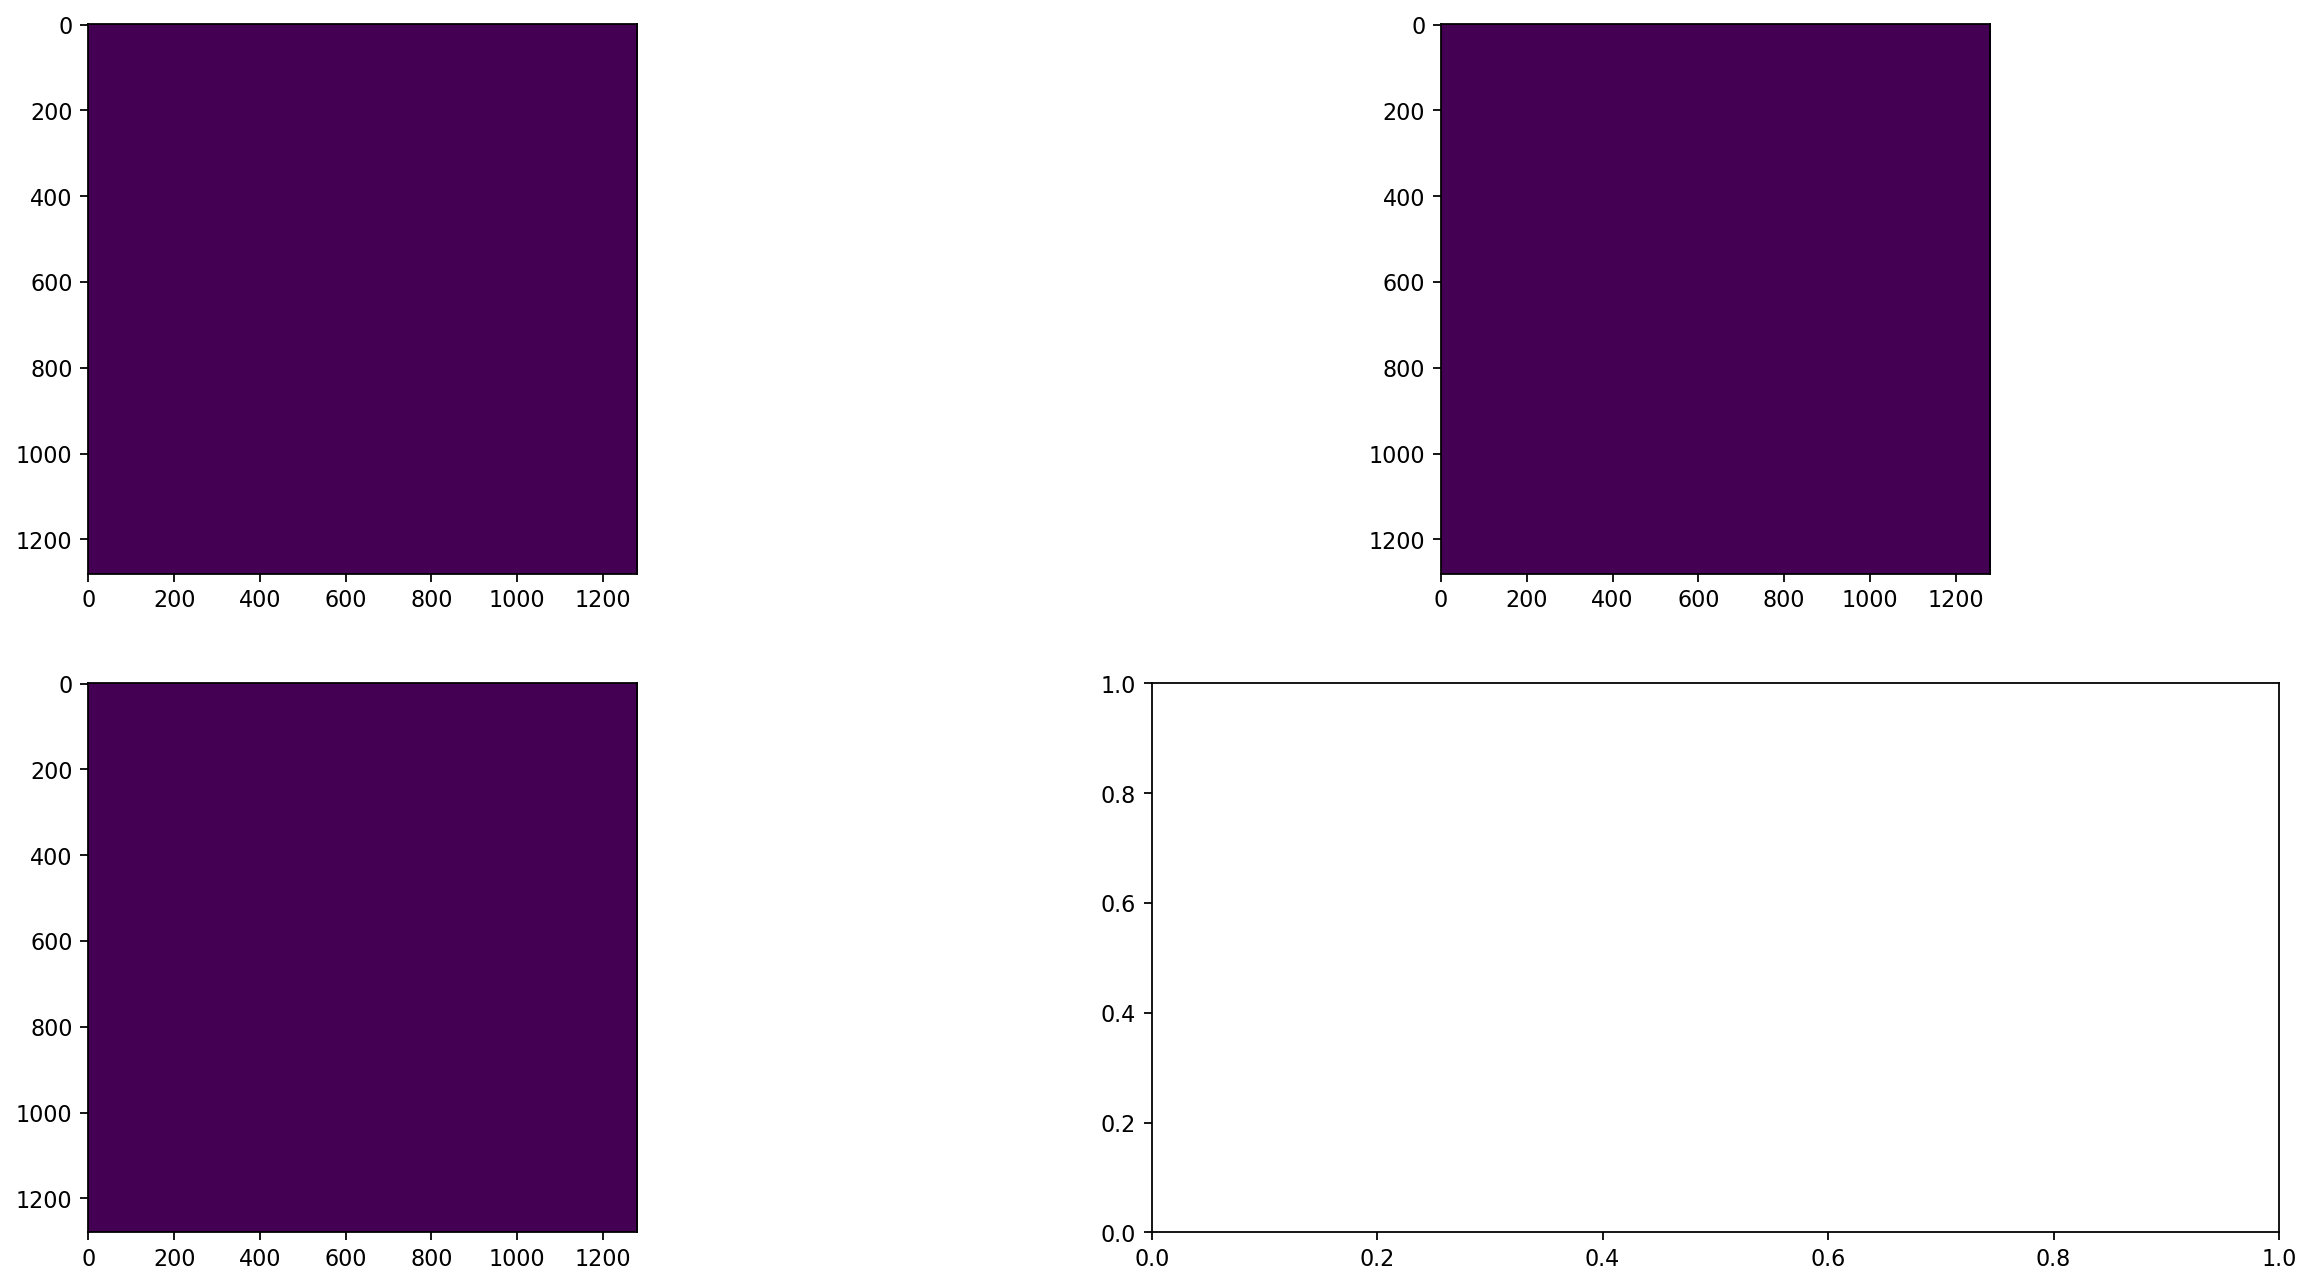

In [145]:
print(potentials.__sizeof__()/1024/1024, potentials.nbytes/1024/1024)
#plt.imshow((template[:,:,-1, 3]))
print(np.argmax(np.sum(np.abs(potentials[:,:,:,3]), axis=(0,1))))
#print((np.sum(np.abs(potentials[:,:,:,3]), axis=(0,1))))
#plt.colorbar()
print(np.amax(potentials[:,:,:,3]), np.amin(potentials[:,:,:,3]))
#print(potentials[:,:,5,3])

from ipywidgets import interact

@interact(x=(0,potentials.shape[2]-1))
def show_slice(x):
    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(potentials[:,:,x, 0])
    ax[0,1].imshow(potentials[:,:,x, 1])
    ax[1,0].imshow(potentials[:,:,x, 2])
    im = ax[1,1].imshow(potentials[:,:,x,3]/np.abs(potentials[:,:,x,3]) * np.log10(1+np.abs(potentials[:,:,x, 3]*np.log(10))))
    fig.colorbar(im, ax=ax[1,1])
    #for i in [0,1]:
    #    for j in [0,1]:
    #        ax[i,j].colorbar()
    fig.tight_layout()
    plt.show()

In [ ]:
backup_atoms = atom_pos
backup_spc = atom_spc

[ 1.371  3.656  7.841 26.999 15.484  3.378 22.545 12.721 18.961 18.624]


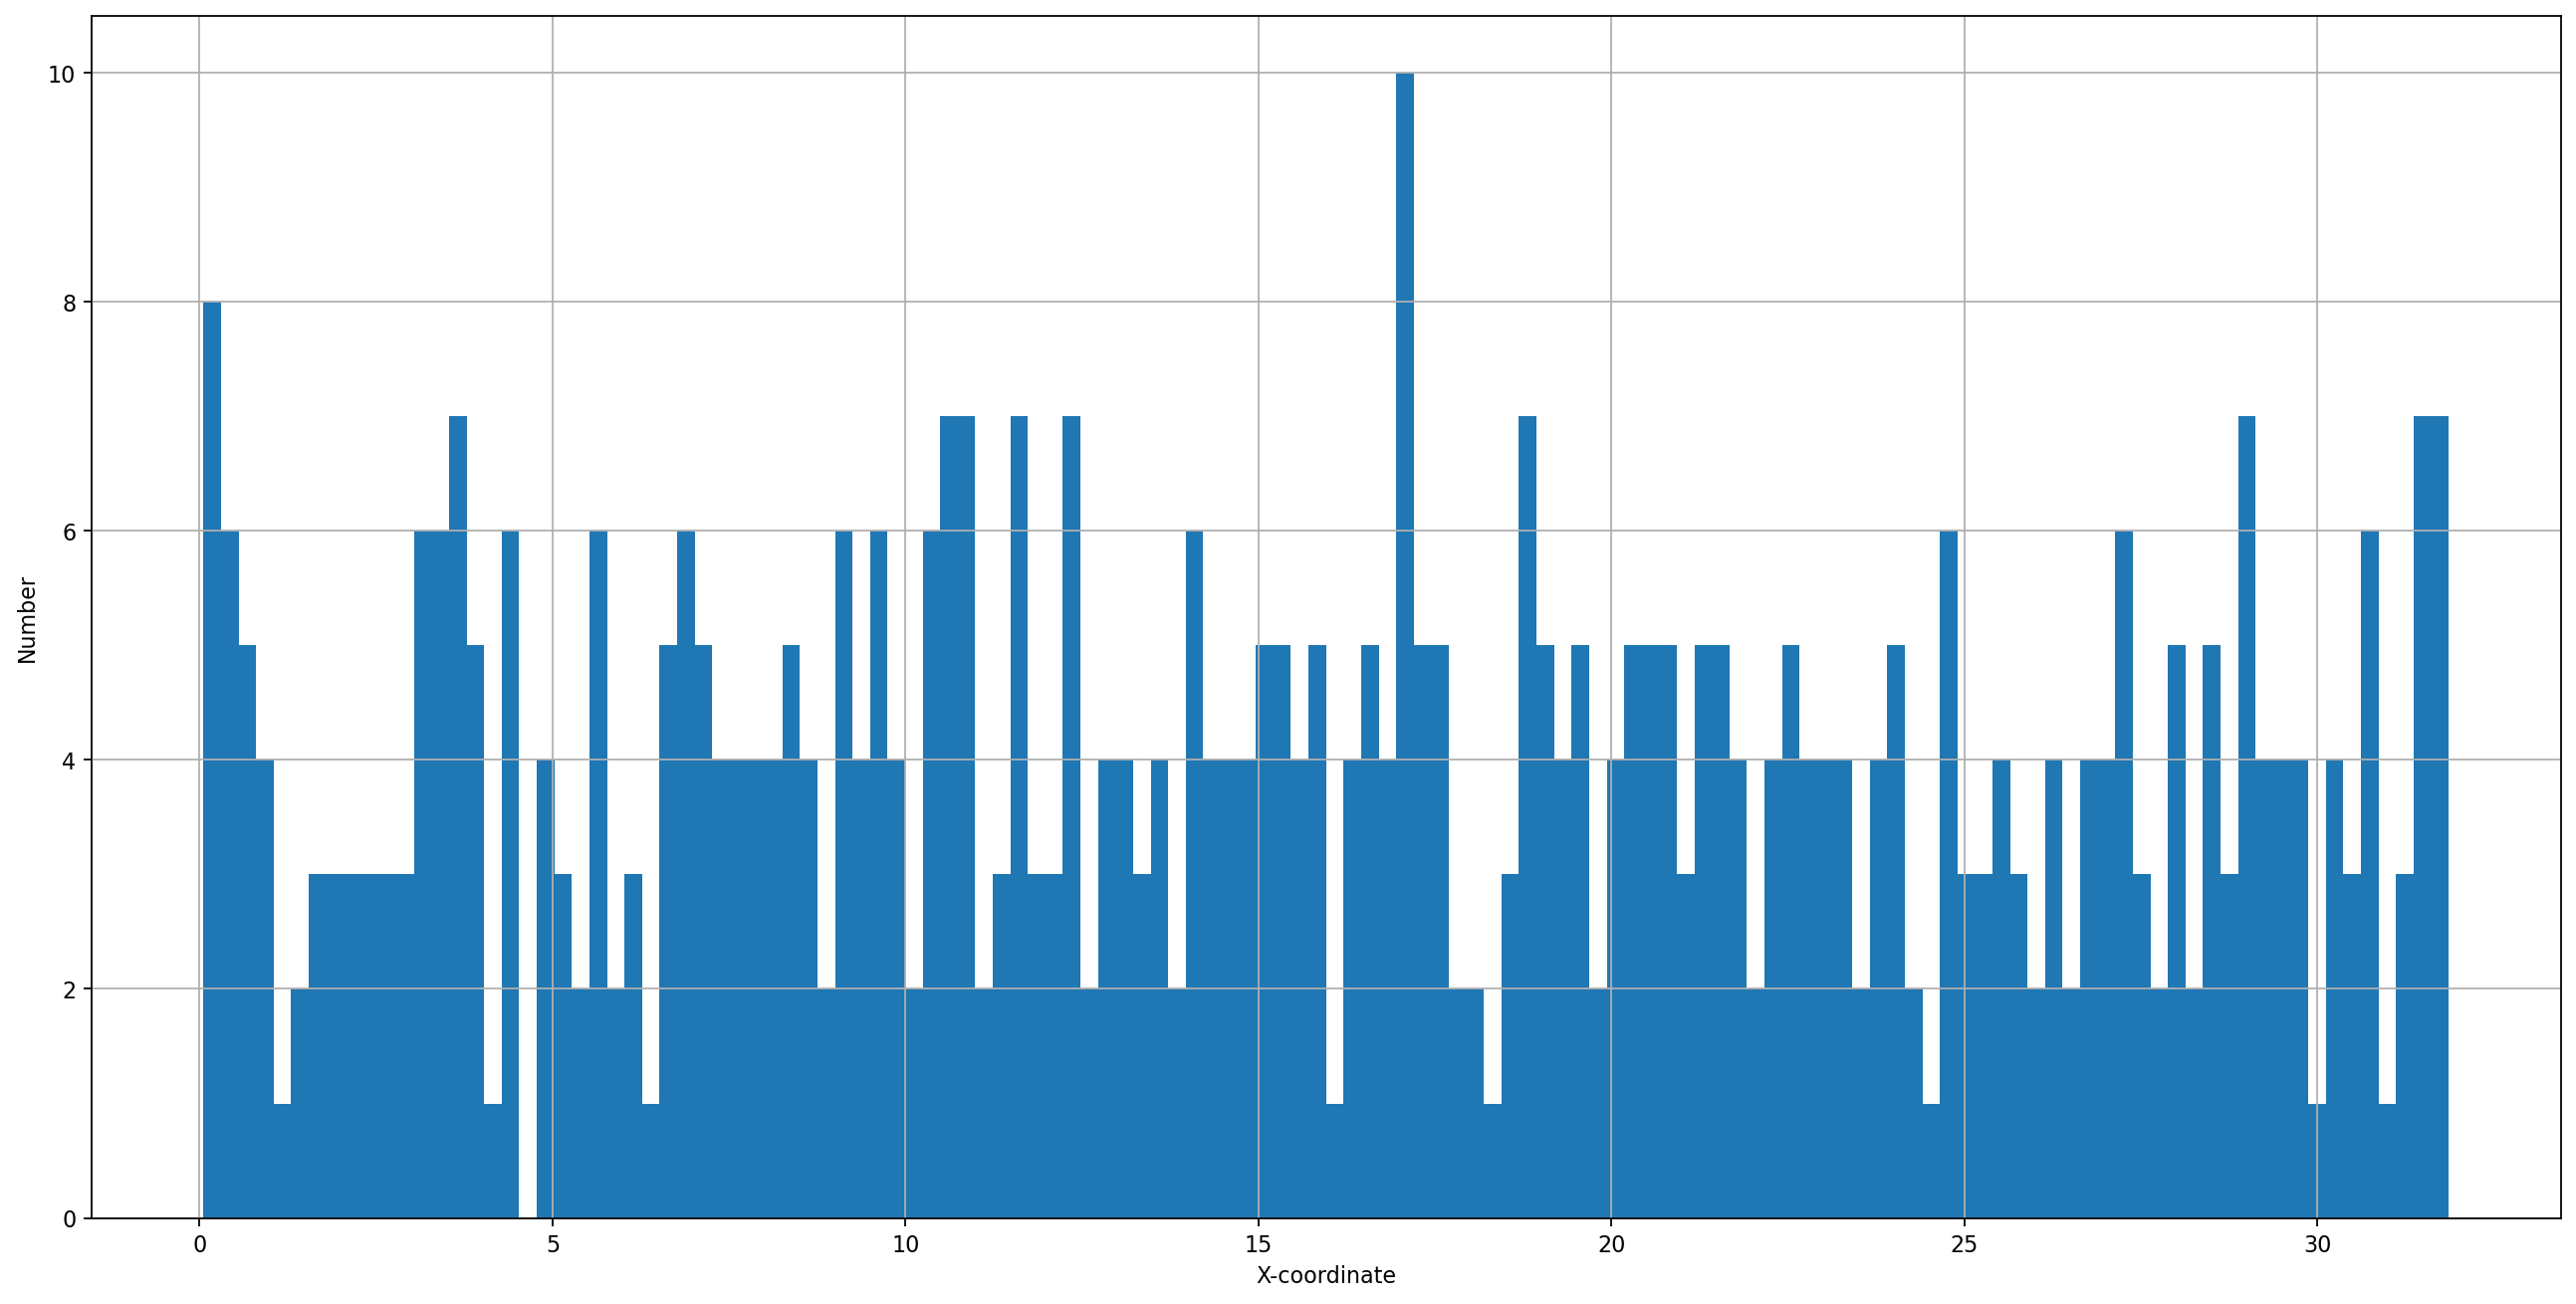

In [74]:
print(dests[:10,0])
n, b, p = plt.hist(dests[:,0], 128)

plt.xlabel("X-coordinate")
plt.ylabel("Number")
plt.grid(True)
plt.show()

In [ ]:
# plot Lennard-Jones potential
r = np.arange(0.5,5,0.01)
p1 = (zero_pot/r)**12 - (zero_pot/r)**6
p2 = A*(zero_pot/r)**12 - R*(zero_pot/r)**6

fig, ax = plt.subplots(2)
ax[0].plot(r, p1)
ax[1].plot(r, p2)

fig.tight_layout()
plt.show()